# Models lineals (III)
## **Regressió Logística**

La regressió logística és una tècnica estadística i d'aprenentatge automàtic utilitzada principalment per a tasques de classificació binària, tot i que també es pot generalitzar per a múltiples categories. El seu objectiu és modelar la probabilitat que una observació pertanyi a una classe específica basant-se en un conjunt de variables predictives (també anomenades característiques o atributs).

A diferència de la regressió lineal, que prediu valors continus, **la regressió logística prediu una probabilitat, un valor comprès entre 0 i 1.** Per aconseguir-ho, utilitza una funció sigmoide o logística, que transforma qualsevol entrada (que pot anar de $-\infty$ a $+\infty$) en un valor comprès en aquest interval.

## Començam

En aquest exemple, utilitzarem la regressió logística per a la classificació de dades. Les dades seran generades de manera sintètica mitjançant la funció ``make_moons`` de la llibreria ``scikit-learn``. Aquesta funció crea un conjunt de dades amb una distribució de dos tipus de classes en forma de dues llunes, una classe en cada "meitat" de les llunes.

### Importam les llibreries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.conftest import xp_skip_np_only_backends

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


### Cream les dades

In [2]:
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)

# Informació del dataset
print(f"Nombre de mostres: {X.shape[0]}")
print(f"Nombre de característiques: {X.shape[1]}")
print("Classes:", np.unique(y))

Nombre de mostres: 300
Nombre de característiques: 2
Classes: [0 1]


### K-Fold

*K-Fold Cross Validation* és una tècnica d'avaluació de models que ajuda a obtenir una mesura més robusta del rendiment d'un model de classificació, especialment quan es disposa d'un conjunt de dades limitat. Aquesta tècnica divideix el conjunt de dades en **k** subconjunts o "folds", i utilitza cada subconjunt en múltiples etapes per entrenar i validar el model. Així es pot obtenir una estimació més fiable de la capacitat del model de generalitzar a noves dades.

![K-Fold](imgs/kfold.png)

Per fer aquesta tasca tornam a utilitzar ``scikit-learn``. Particularmnet, la funció [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). Aquesta funció té els següents paràmetres: 

- **n_splits**. Nombre de divisions a fer.
- **shuffle**. Booleà indicant si s'ha de mesclar la informació abans de dividir-la
- **random_stat**. Llavor aleatòria.

Retorna les diferents divisions de train i *test*, tot seguint la distribució de la mida d'entrenament sigui $k-1$ i la de test $1$. Feim una funció que ho engloba. En aquest cas el més habitual és fer la divisió de les dades en tres conjunts:

1. Entrenament. Conté la major part de les dades disponibles, i el model ajusta els seus paràmetres per minimitzar l'error en aquestes dades.
2. Validació. S'utilitza per avaluar el model durant l'entrenament i ajustar-ne els hiperparàmetres.
3. Aquest conjunt només s'utilitza després de completar l'entrenament i ajustar el model. Serveix per avaluar com de bé el model generalitza a dades totalment noves i mai vistes abans.

In [3]:
def cross_validate(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))

    return np.mean(scores), scores, model

Empram el model de classificació de la regressió logística.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [5]:
model = LogisticRegression()

# Avaluació inicial amb k-folds
mean_accuracy, fold_accuracies, model = cross_validate(model, X_train, y_train, k=5)
print(f"Accuracy mitjana (5 folds): {mean_accuracy:.2f}")
print("Accuracy per cada fold:", fold_accuracies)

Accuracy mitjana (5 folds): 0.84
Accuracy per cada fold: [0.8048780487804879, 0.825, 0.875, 0.825, 0.875]


## Optimització d'Hiperparàmetres amb GridSearchCV

Fins ara hem utilitzat la `LogisticRegression` amb els seus hiperparàmetres per defecte. No obstant això, en l'aprenentatge automàtic, com ja sabeu, la majoria de models tenen **hiperparàmetres** que nosaltres hem de configurar abans de l'entrenament.

Si voleu saber quins hiperparàmetres té cada model podeu visitar la pàgina de [``scikit-learn``](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#) corresponent.

Per saber quina és la millor configuració de hiperparàmetres tenim l'eina **GridSearchCV** de `scikit-learn` que automatitza aquest procés:

1.  Defineix una "graella" (grid) amb valors possibles per a diferents hiperparàmetres.
2.  Entrena un model per a cada combinació possible.
3.  Utilitza **Cross-Validation** (com hem vist abans) per avaluar cada combinació.
4.  Retorna el model amb la millor puntuació.


A continuació, cercarem la millor configuració per al paràmetre `C` (l'invers de la força de regularització) i el tipus de `solver` (l'algoritme matemàtic per trobar els pesos).

In [7]:
# 1. Definim la graella d'hiperparàmetres a explorar
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # Valors petits = molta regularització, grans = poca
    'solver': ['lbfgs', 'liblinear'],  # Diferents algorismes d'optimització
}

# 2. Configurem el GridSearchCV
# cv=5 indica que farà servir 5-Fold Cross Validation internament
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Utilitza tots els processadors disponibles
)

grid_search.fit(X_train, y_train)

# 4. Resultats
print("-" * 30)
print(f"Millors paràmetres trobats: {grid_search.best_params_}")
print(f"Millor accuracy (validació creuada): {grid_search.best_score_:.2f}")

# 5. Actualitzem la variable 'model' amb el millor estimador trobat
model = grid_search.best_estimator_

# Avaluació final sobre el conjunt de test (que no s'ha fet servir per triar paràmetres)
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))

------------------------------
Millors paràmetres trobats: {'C': 10, 'solver': 'lbfgs'}
Millor accuracy (validació creuada): 0.87
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        46
           1       0.87      0.91      0.89        53

    accuracy                           0.88        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.88      0.88      0.88        99



## Resultats

### Matriu de confusió

Una matriu de confusió és una eina utilitzada en l'avaluació del rendiment d’un model de classificació. Proporciona una representació visual de com el model ha classificat les dades, mostrant la correspondència entre les etiquetes reals i les prediccions fetes pel model.

Es tracta d'una taula que generalment té les següents característiques:
- Les files representen les classes reals (etiquetes correctes).
- Les columnes representen les classes predites pel model.

És especialment útil en situacions a on les classes estan desequilibrades, ja que permet identificar possibles biaixos del model.



<Axes: >

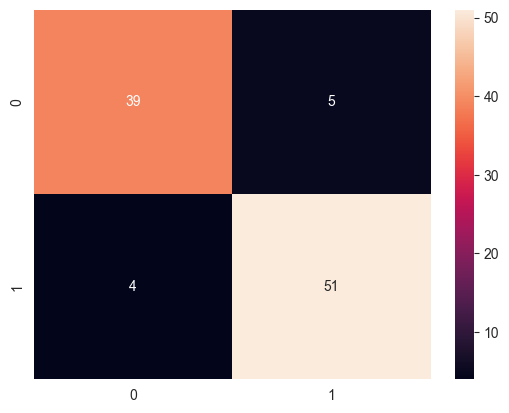

In [7]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

In [8]:
# Informe de classificació
print("Informe de classificació:")
print(classification_report(y_test, y_pred))

Informe de classificació:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        44
           1       0.91      0.93      0.92        55

    accuracy                           0.91        99
   macro avg       0.91      0.91      0.91        99
weighted avg       0.91      0.91      0.91        99

